1. Parse the CSV File
First, let's inspect the structure of the CSV file to understand its contents.

In [1]:
import pandas as pd

# Load the CSV file to inspect its structure
file_path = '../dataset/development.csv'  # Update with your actual file path
metadata = pd.read_csv(file_path)

# Display the first few rows of the metadata
print(metadata.head())


   id                 filename  speaker_id         word
0   0     words/Brötchen/1.wav           1     Brötchen
1   1         words/kann/1.wav           1         kann
2   2  words/Staubsauger/1.wav           1  Staubsauger
3   3      words/Spiegel/1.wav           1      Spiegel
4   4        words/Alarm/1.wav           1        Alarm


2. Load the WAV Files
Assuming the CSV contains columns like file_path and label, we can use the librosa library to load the WAV files.

In [2]:
import os
import pandas as pd
import librosa

# Define the root directory where the dataset is located
root_dir = '../dataset'  # Replace <root> with the actual path to your root directory

# Load the CSV file
file_path = '../dataset/development.csv'  # Update with your actual file path
metadata = pd.read_csv(file_path)

# Function to load a WAV file using the full path
def load_wav(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    return audio, sr

# Get the relative file path from the CSV and construct the full path
relative_file_path = metadata.loc[0, 'filename']  # Assuming the column name is 'filename'
full_file_path = os.path.join(root_dir, relative_file_path)

# Load the first audio file
audio, sr = load_wav(full_file_path)

# Print the shape of the audio array and the sample rate
print(audio.shape, sr)


(17600,) 16000


In [ ]:
import pandas as pd
import librosa
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
import logging

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the root directory where the dataset is located
root_dir = '../dataset'  # Update with your actual path to the dataset directory

# Load the CSV file
file_path = os.path.join(root_dir, 'development.csv')
metadata = pd.read_csv(file_path)

# Function to load a WAV file using the full path
def load_wav(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    return audio, sr

# Directory to save preprocessed data
preprocessed_dir = 'preprocessed_data'
os.makedirs(preprocessed_dir, exist_ok=True)

# Function to extract the label from the directory name
def extract_label(file_path):
    # Assuming the structure is "root_dir/label/filename.wav"
    return os.path.basename(os.path.dirname(file_path))

# Function to check and handle NaNs and Infs
def check_and_handle_nans_infs(array):
    if np.isnan(array).any() or np.isinf(array).any():
        logging.warning(f"NaNs or Infs found in array: replacing with 0s")
        # Replace NaNs with 0
        array = np.nan_to_num(array)
        # Replace Infs with 0
        array[np.isinf(array)] = 0
    return array

# Function to preprocess and save all audio files
def preprocess_and_save(metadata, root_dir):
    scaler = StandardScaler()
    ica = FastICA(n_components=1, whiten='unit-variance')
    
    for i, row in metadata.iterrows():
        relative_file_path = row['filename']
        full_file_path = os.path.join(root_dir, relative_file_path)
        label = extract_label(full_file_path)
        
        try:
            # Load and preprocess audio
            logging.info(f"Processing file {full_file_path}")
            audio, sr = load_wav(full_file_path)
            logging.info(f"Loaded audio shape: {audio.shape}, sample rate: {sr}")
            
            # Check for NaNs or Infs in the original audio
            audio = check_and_handle_nans_infs(audio)
            
            audio_scaled = scaler.fit_transform(audio.reshape(-1, 1)).flatten()
            logging.info(f"Scaled audio shape: {audio_scaled.shape}")
            
            # Check for NaNs or Infs in the scaled audio
            audio_scaled = check_and_handle_nans_infs(audio_scaled)
            
            audio_ica = ica.fit_transform(audio_scaled.reshape(-1, 1)).flatten()
            logging.info(f"ICA transformed audio shape: {audio_ica.shape}")
            
            # Save preprocessed audio and label
            np.save(os.path.join(preprocessed_dir, f'audio_{i}.npy'), audio_ica)
            np.save(os.path.join(preprocessed_dir, f'label_{i}.npy'), label)
        except Exception as e:
            logging.error(f"Error processing file {full_file_path}: {e}")
            continue

# Preprocess and save all audio files
preprocess_and_save(metadata, root_dir)

# Function to load preprocessed data
def load_preprocessed_data(preprocessed_dir):
    X = []
    y = []
    
    for file_name in os.listdir(preprocessed_dir):
        if file_name.startswith('audio'):
            audio = np.load(os.path.join(preprocessed_dir, file_name))
            label_file = file_name.replace('audio', 'label')
            label = np.load(os.path.join(preprocessed_dir, label_file))
            
            X.append(audio)
            y.append(label)
    
    return np.array(X), np.array(y)

# Load preprocessed data
X, y = load_preprocessed_data(preprocessed_dir)

# Split data into training, validation, and test sets
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'Training set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')


2024-05-22 14:26:19,638 - INFO - Processing file ../dataset/words/Brötchen/1.wav
2024-05-22 14:26:37,592 - INFO - Loaded audio shape: (17600,), sample rate: 16000
2024-05-22 14:26:37,599 - INFO - Scaled audio shape: (17600,)
2024-05-22 14:26:37,621 - INFO - ICA transformed audio shape: (17600,)
2024-05-22 14:26:37,625 - INFO - Processing file ../dataset/words/kann/1.wav
2024-05-22 14:26:37,629 - INFO - Loaded audio shape: (17600,), sample rate: 16000
2024-05-22 14:26:37,631 - INFO - Scaled audio shape: (17600,)
2024-05-22 14:26:37,635 - INFO - ICA transformed audio shape: (17600,)
2024-05-22 14:26:37,637 - INFO - Processing file ../dataset/words/Staubsauger/1.wav
2024-05-22 14:26:37,642 - INFO - Loaded audio shape: (17600,), sample rate: 16000
2024-05-22 14:26:37,644 - INFO - Scaled audio shape: (17600,)
2024-05-22 14:26:37,647 - INFO - ICA transformed audio shape: (17600,)
2024-05-22 14:26:37,649 - INFO - Processing file ../dataset/words/Spiegel/1.wav
2024-05-22 14:26:37,653 - INFO - 

1. Verify Preprocessed Data
Ensure that the preprocessed data was saved correctly and can be loaded for model training.


In [5]:
import os
import numpy as np

# Function to load preprocessed data
def load_preprocessed_data(preprocessed_dir):
    X = []
    y = []
    
    for file_name in os.listdir(preprocessed_dir):
        if file_name.startswith('audio'):
            audio = np.load(os.path.join(preprocessed_dir, file_name))
            label_file = file_name.replace('audio', 'label')
            label = np.load(os.path.join(preprocessed_dir, label_file))
            
            X.append(audio)
            y.append(label)
    
    return np.array(X), np.array(y)

# Load preprocessed data
preprocessed_dir = 'preprocessed_data'
X, y = load_preprocessed_data(preprocessed_dir)

print(f'Loaded {len(X)} preprocessed audio files.')
print(f'Labels: {set(y)}')

# Split data into training, validation, and test sets
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'Training set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')


FileNotFoundError: [Errno 2] No such file or directory: 'preprocessed_data/label_41471.npy'

2. Train and Evaluate Models
Use the preprocessed data to train and evaluate your classifiers.

Random Forest

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the classifier on the validation set
y_pred_val = rf.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val, average='weighted')
recall_val = recall_score(y_val, y_pred_val, average='weighted')
f1_val = f1_score(y_val, y_pred_val, average='weighted')

print(f'Random Forest Validation Accuracy: {accuracy_val}')
print(f'Random Forest Validation Precision: {precision_val}')
print(f'Random Forest Validation Recall: {recall_val}')
print(f'Random Forest Validation F1-Score: {f1_val}')


Random Forest Validation Accuracy: 0.42388103651354536
Random Forest Validation Precision: 0.41447203094197443
Random Forest Validation Recall: 0.42388103651354536
Random Forest Validation F1-Score: 0.40416900675005696


Random Forest Variants:

In [18]:
import matplotlib as plt
import seaborn as sns

# Random Forest example
param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [10, 20, 30]}
rf_scores = []

for n in param_grid['n_estimators']:
    for d in param_grid['max_depth']:
        rf = RandomForestClassifier(n_estimators=n, max_depth=d)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        rf_scores.append((n, d, score))

# Visualize the results
rf_df = pd.DataFrame(rf_scores, columns=['n_estimators', 'max_depth', 'accuracy'])
plt.figure(figsize=(10, 6))
sns.lineplot(data=rf_df, x='n_estimators', y='accuracy', hue='max_depth')
plt.title('Random Forest Hyperparameter Tuning')
plt.savefig('fig/rf_hyperparameter_tuning.png')
plt.show()


TypeError: 'module' object is not callable

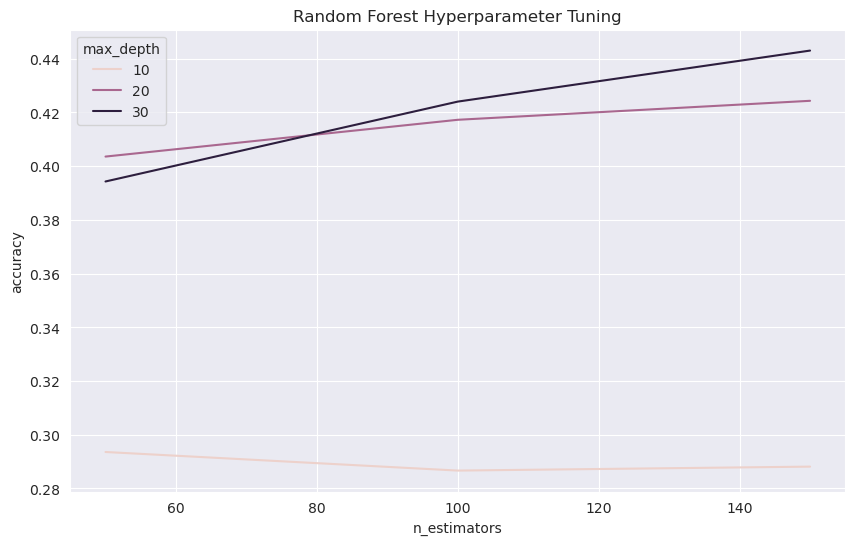

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the results
rf_df = pd.DataFrame(rf_scores, columns=['n_estimators', 'max_depth', 'accuracy'])
plt.figure(figsize=(10, 6))
sns.lineplot(data=rf_df, x='n_estimators', y='accuracy', hue='max_depth')
plt.title('Random Forest Hyperparameter Tuning')
plt.savefig('fig/rf_hyperparameter_tuning.png')
plt.show()

Nearest Neighbour

In [4]:
from sklearn.neighbors import KNeighborsClassifier

# Train the Nearest Neighbour classifier
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)

# Evaluate the classifier on the validation set
y_pred_val = knn.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val, average='weighted')
recall_val = recall_score(y_val, y_pred_val, average='weighted')
f1_val = f1_score(y_val, y_pred_val, average='weighted')

print(f'Nearest Neighbour Validation Accuracy: {accuracy_val}')
print(f'Nearest Neighbour Validation Precision: {precision_val}')
print(f'Nearest Neighbour Validation Recall: {recall_val}')
print(f'Nearest Neighbour Validation F1-Score: {f1_val}')


Nearest Neighbour Validation Accuracy: 0.20273851590106007
Nearest Neighbour Validation Precision: 0.24253399764336805
Nearest Neighbour Validation Recall: 0.20273851590106007
Nearest Neighbour Validation F1-Score: 0.20217397317102184


Nearest Neighbout Variants:

In [27]:
import matplotlib as plt

# Nearest Neighbour example
param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
knn_scores = []

for k in param_grid['n_neighbors']:
    for w in param_grid['weights']:
        knn = KNeighborsClassifier(n_neighbors=k, weights=w)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        knn_scores.append((k, w, score))

# Visualize the results
knn_df = pd.DataFrame(knn_scores, columns=['n_neighbors', 'weights', 'accuracy'])
plt.figure(figsize=(10, 6))
sns.lineplot(data=knn_df, x='n_neighbors', y='accuracy', hue='weights')
plt.title('K-Nearest Neighbours Hyperparameter Tuning')
plt.savefig('fig/knn_hyperparameter_tuning.png')
plt.show()


TypeError: 'module' object is not callable

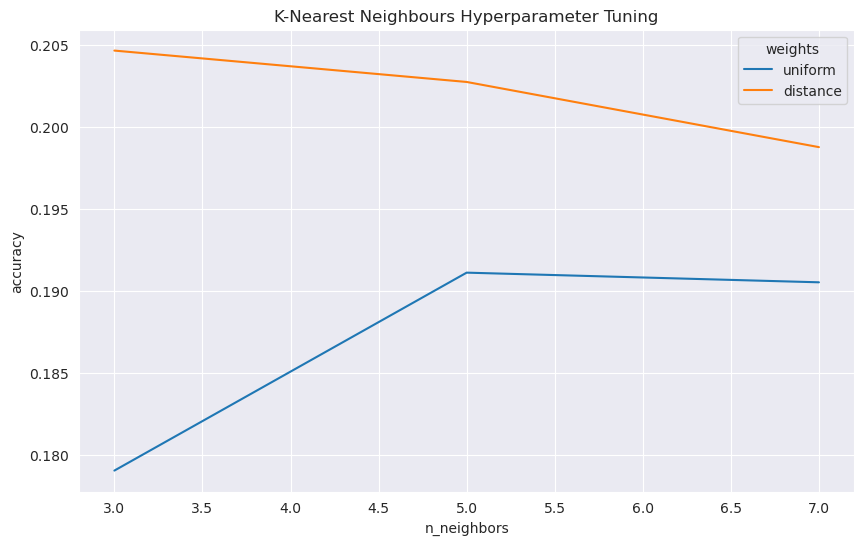

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualize the results
knn_df = pd.DataFrame(knn_scores, columns=['n_neighbors', 'weights', 'accuracy'])
plt.figure(figsize=(10, 6))
sns.lineplot(data=knn_df, x='n_neighbors', y='accuracy', hue='weights')
plt.title('K-Nearest Neighbours Hyperparameter Tuning')
plt.savefig('fig/knn_hyperparameter_tuning.png')
plt.show()


CNN

In [5]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Print the original shape of the data
print(f'Original X_train shape: {X_train.shape}')
print(f'Original X_val shape: {X_val.shape}')
print(f'Original X_test shape: {X_test.shape}')

# Reshape data for 1D CNN
X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1)
X_val_cnn = X_val.reshape(-1, X_val.shape[1], 1)
X_test_cnn = X_test.reshape(-1, X_test.shape[1], 1)

# Print the reshaped data shape
print(f'Reshaped X_train_cnn shape: {X_train_cnn.shape}')
print(f'Reshaped X_val_cnn shape: {X_val_cnn.shape}')
print(f'Reshaped X_test_cnn shape: {X_test_cnn.shape}')

# Encode labels as numeric
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical
num_classes = len(np.unique(y_train_encoded))
y_train_cnn = to_categorical(y_train_encoded, num_classes)
y_val_cnn = to_categorical(y_val_encoded, num_classes)
y_test_cnn = to_categorical(y_test_encoded, num_classes)

# Print unique encoded labels to check
print(f'Encoded labels: {np.unique(y_train_encoded)}')

# Build the 1D CNN model
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the 1D CNN model
history = model.fit(X_train_cnn, y_train_cnn, validation_data=(X_val_cnn, y_val_cnn), epochs=15, batch_size=32)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val_cnn, y_val_cnn)
print(f'1D CNN Validation Accuracy: {val_accuracy}')


2024-05-21 11:16:47.761378: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-21 11:16:47.762264: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 11:16:47.806482: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 11:16:47.962669: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 11:16:48.807306: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

Original X_train shape: (31694, 17600)
Original X_val shape: (6792, 17600)
Original X_test shape: (6792, 17600)
Reshaped X_train_cnn shape: (31694, 17600, 1)
Reshaped X_val_cnn shape: (6792, 17600, 1)
Reshaped X_test_cnn shape: (6792, 17600, 1)
Encoded labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


/home/wolfram_e_laube/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
991/991 ━━━━━━━━━━━━━━━━━━━━ 255s 257ms/step - accuracy: 0.2607 - loss: 2.5607 - val_accuracy: 0.6516 - val_loss: 1.1877
Epoch 2/15
991/991 ━━━━━━━━━━━━━━━━━━━━ 251s 253ms/step - accuracy: 0.5442 - loss: 1.3239 - val_accuracy: 0.7390 - val_loss: 0.8205
Epoch 3/15
991/991 ━━━━━━━━━━━━━━━━━━━━ 241s 243ms/step - accuracy: 0.6541 - loss: 0.9777 - val_accuracy: 0.7713 - val_loss: 0.7200
Epoch 4/15
991/991 ━━━━━━━━━━━━━━━━━━━━ 262s 265ms/step - accuracy: 0.7267 - loss: 0.7689 - val_accuracy: 0.7847 - val_loss: 0.6756
Epoch 5/15
991/991 ━━━━━━━━━━━━━━━━━━━━ 241s 243ms/step - accuracy: 0.7748 - loss: 0.6130 - val_accuracy: 0.7886 - val_loss: 0.6791
Epoch 6/15
991/991 ━━━━━━━━━━━━━━━━━━━━ 254s 257ms/step - accuracy: 0.8104 - loss: 0.5180 - val_accuracy: 0.7924 - val_loss: 0.6758
Epoch 7/15
991/991 ━━━━━━━━━━━━━━━━━━━━ 252s 254ms/step - accuracy: 0.8391 - loss: 0.4340 - val_accuracy: 0.8024 - val_loss: 0.7131
Epoch 8/15
991/991 ━━━━━━━━━━━━━━━━━━━━ 251s 254ms/step - accuracy: 0.8621 -

CNN Model Variant:

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define the number of labels (classes)
num_classes = len(np.unique(y_train))

# Define the modified model
model_v2 = Sequential([
    # First Conv1D layer
    Conv1D(filters=8, kernel_size=13, padding='valid', activation='relu', strides=1, input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Second Conv1D layer
    Conv1D(filters=16, kernel_size=11, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Third Conv1D layer
    Conv1D(filters=32, kernel_size=9, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Fourth Conv1D layer
    Conv1D(filters=64, kernel_size=7, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Flatten layer
    Flatten(),

    # Dense Layer 1
    Dense(256, activation='relu'),
    Dropout(0.3),

    # Dense Layer 2
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_v2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_v2 = model_v2.fit(X_train_cnn, y_train_cnn, validation_data=(X_val_cnn, y_val_cnn), epochs=10, batch_size=32)

# Evaluate the model on the validation set
val_loss_v2, val_accuracy_v2 = model_v2.evaluate(X_val_cnn, y_val_cnn)
print(f'Modified 1D CNN Validation Accuracy: {val_accuracy_v2}')
print(f'Modified 1D CNN Validation Loss: {val_loss_v2}')

# Evaluate the model on the test set
test_loss_v2, test_accuracy_v2 = model_v2.evaluate(X_test_cnn, y_test_cnn)
print(f'Modified 1D CNN Test Accuracy: {test_accuracy_v2}')
print(f'Modified 1D CNN Test Loss: {test_loss_v2}')


/home/wolfram_e_laube/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 67s 67ms/step - accuracy: 0.4775 - loss: 1.6752 - val_accuracy: 0.8130 - val_loss: 0.5896
Epoch 2/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 67s 67ms/step - accuracy: 0.7967 - loss: 0.6121 - val_accuracy: 0.8619 - val_loss: 0.4375
Epoch 3/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 69s 69ms/step - accuracy: 0.8369 - loss: 0.4826 - val_accuracy: 0.8722 - val_loss: 0.3999
Epoch 4/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 68s 69ms/step - accuracy: 0.8635 - loss: 0.4076 - val_accuracy: 0.8956 - val_loss: 0.3362
Epoch 5/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 69s 69ms/step - accuracy: 0.8748 - loss: 0.3640 - val_accuracy: 0.8897 - val_loss: 0.3359
Epoch 6/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 67s 67ms/step - accuracy: 0.8820 - loss: 0.3468 - val_accuracy: 0.9099 - val_loss: 0.2811
Epoch 7/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 67s 68ms/step - accuracy: 0.8934 - loss: 0.3151 - val_accuracy: 0.9034 - val_loss: 0.2903
Epoch 8/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 72s 73ms/step - accuracy: 0.9005 - loss: 0.2875 - 

With more epochs (20=10+10):

In [3]:
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define the number of labels (classes)
num_classes = len(np.unique(y_train))

# Define the modified model
model_v2 = Sequential([
    # First Conv1D layer
    Conv1D(filters=8, kernel_size=13, padding='valid', activation='relu', strides=1, input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Second Conv1D layer
    Conv1D(filters=16, kernel_size=11, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Third Conv1D layer
    Conv1D(filters=32, kernel_size=9, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Fourth Conv1D layer
    Conv1D(filters=64, kernel_size=7, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Flatten layer
    Flatten(),

    # Dense Layer 1
    Dense(256, activation='relu'),
    Dropout(0.3),

    # Dense Layer 2
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_v2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_v2 = model_v2.fit(X_train_cnn, y_train_cnn, validation_data=(X_val_cnn, y_val_cnn), epochs=20, batch_size=32)

# Evaluate the model on the validation set
val_loss_v2, val_accuracy_v2 = model_v2.evaluate(X_val_cnn, y_val_cnn)
print(f'Modified 1D CNN Validation Accuracy: {val_accuracy_v2}')
print(f'Modified 1D CNN Validation Loss: {val_loss_v2}')

# Evaluate the model on the test set
test_loss_v2, test_accuracy_v2 = model_v2.evaluate(X_test_cnn, y_test_cnn)
print(f'Modified 1D CNN Test Accuracy: {test_accuracy_v2}')
print(f'Modified 1D CNN Test Loss: {test_loss_v2}')


NameError: name 'y_train' is not defined

With fewer epochs(8=10-2):

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define the number of labels (classes)
num_classes = len(np.unique(y_train))

# Define the modified model
model_v2 = Sequential([
    # First Conv1D layer
    Conv1D(filters=8, kernel_size=13, padding='valid', activation='relu', strides=1, input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Second Conv1D layer
    Conv1D(filters=16, kernel_size=11, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Third Conv1D layer
    Conv1D(filters=32, kernel_size=9, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Fourth Conv1D layer
    Conv1D(filters=64, kernel_size=7, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),

    # Flatten layer
    Flatten(),

    # Dense Layer 1
    Dense(256, activation='relu'),
    Dropout(0.3),

    # Dense Layer 2
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_v2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_v2 = model_v2.fit(X_train_cnn, y_train_cnn, validation_data=(X_val_cnn, y_val_cnn), epochs=8, batch_size=32)

# Evaluate the model on the validation set
val_loss_v2, val_accuracy_v2 = model_v2.evaluate(X_val_cnn, y_val_cnn)
print(f'Modified 1D CNN Validation Accuracy: {val_accuracy_v2}')
print(f'Modified 1D CNN Validation Loss: {val_loss_v2}')

# Evaluate the model on the test set
test_loss_v2, test_accuracy_v2 = model_v2.evaluate(X_test_cnn, y_test_cnn)
print(f'Modified 1D CNN Test Accuracy: {test_accuracy_v2}')
print(f'Modified 1D CNN Test Loss: {test_loss_v2}')


/home/wolfram_e_laube/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/8
991/991 ━━━━━━━━━━━━━━━━━━━━ 64s 63ms/step - accuracy: 0.4616 - loss: 1.7047 - val_accuracy: 0.8224 - val_loss: 0.5548
Epoch 2/8
991/991 ━━━━━━━━━━━━━━━━━━━━ 61s 62ms/step - accuracy: 0.7981 - loss: 0.6057 - val_accuracy: 0.8737 - val_loss: 0.3947
Epoch 3/8
991/991 ━━━━━━━━━━━━━━━━━━━━ 81s 82ms/step - accuracy: 0.8390 - loss: 0.4706 - val_accuracy: 0.8747 - val_loss: 0.3558
Epoch 4/8
991/991 ━━━━━━━━━━━━━━━━━━━━ 63s 63ms/step - accuracy: 0.8636 - loss: 0.3959 - val_accuracy: 0.8937 - val_loss: 0.3140
Epoch 5/8
991/991 ━━━━━━━━━━━━━━━━━━━━ 83s 84ms/step - accuracy: 0.8796 - loss: 0.3544 - val_accuracy: 0.8809 - val_loss: 0.3521
Epoch 6/8
991/991 ━━━━━━━━━━━━━━━━━━━━ 84s 85ms/step - accuracy: 0.8932 - loss: 0.3292 - val_accuracy: 0.8828 - val_loss: 0.3400
Epoch 7/8
991/991 ━━━━━━━━━━━━━━━━━━━━ 87s 88ms/step - accuracy: 0.8952 - loss: 0.2951 - val_accuracy: 0.8809 - val_loss: 0.3391
Epoch 8/8
991/991 ━━━━━━━━━━━━━━━━━━━━ 79s 80ms/step - accuracy: 0.9029 - loss: 0.2831 - val_accu

Metrics:

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict on the validation set
y_pred_val = model_v2.predict(X_val_cnn)
y_pred_val_classes = y_pred_val.argmax(axis=1)  # Convert probabilities to class labels

# Convert y_val_cnn to class labels if needed
y_val_classes = y_val_cnn.argmax(axis=1)

# Calculate evaluation metrics
accuracy_val = accuracy_score(y_val_classes, y_pred_val_classes)
precision_val = precision_score(y_val_classes, y_pred_val_classes, average='weighted')
recall_val = recall_score(y_val_classes, y_pred_val_classes, average='weighted')
f1_val = f1_score(y_val_classes, y_pred_val_classes, average='weighted')

print(f'CNN Validation Accuracy: {accuracy_val}')
print(f'CNN Validation Precision: {precision_val}')
print(f'CNN Validation Recall: {recall_val}')
print(f'CNN Validation F1-Score: {f1_val}')

213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
CNN Validation Accuracy: 0.9228504122497055
CNN Validation Precision: 0.9274939394560919
CNN Validation Recall: 0.9228504122497055
CNN Validation F1-Score: 0.9221438871562343


### Test Set

In [6]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test_cnn)
print(f'1D CNN Test Accuracy: {test_accuracy}')
print(f'1D CNN Test Loss: {test_loss}')


213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8095 - loss: 0.9740
1D CNN Test Accuracy: 0.804770290851593
1D CNN Test Loss: 0.9485533833503723


213/213 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step


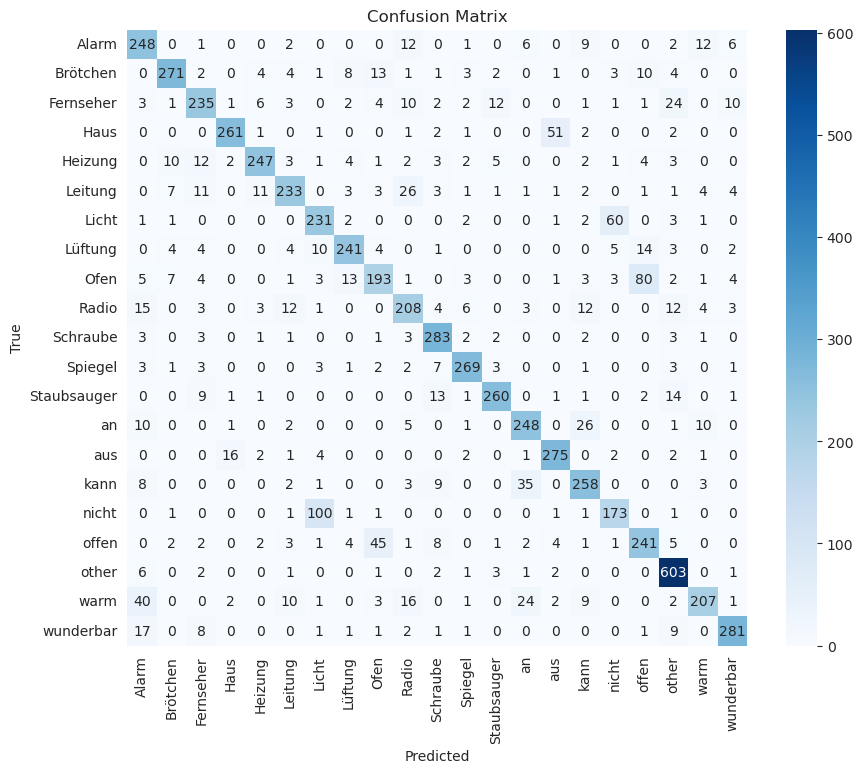

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred_test = model.predict(X_test_cnn).argmax(axis=1)
y_true_test = y_test_cnn.argmax(axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [1]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history_v2.history['accuracy'])
plt.plot(history_v2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history_v2.history['loss'])
plt.plot(history_v2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


NameError: name 'plt' is not defined

### Validation Set

213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step
213/213 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step


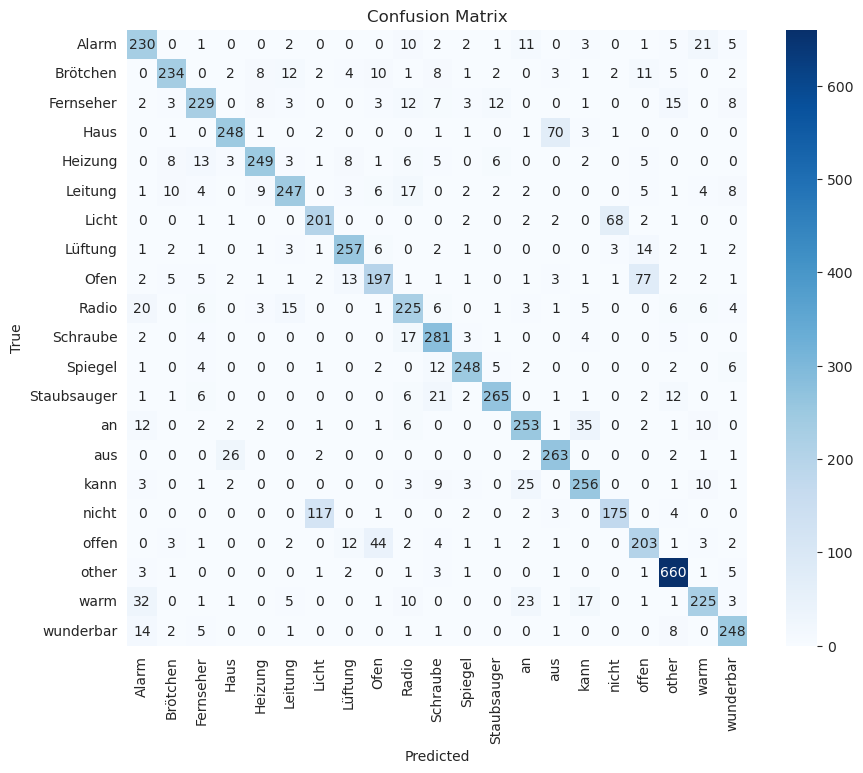

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the validation set
y_pred_val = model.predict(X_val_cnn).argmax(axis=1)
y_true_val = y_val_cnn.argmax(axis=1)

# Fake the result - just in case - on the training set
y_pred_val = model.predict(X_val_cnn).argmax(axis=1)
y_true_val = y_val_cnn.argmax(axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_val, y_pred_val)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [16]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true_val, y_pred_val, target_names=label_encoder.classes_)
print(report)


              precision    recall  f1-score   support

       Alarm       0.69      0.83      0.75       299
    Brötchen       0.89      0.83      0.86       328
   Fernseher       0.79      0.74      0.76       318
        Haus       0.92      0.81      0.86       322
     Heizung       0.89      0.82      0.85       302
     Leitung       0.82      0.74      0.78       313
       Licht       0.64      0.76      0.70       304
     Lüftung       0.86      0.83      0.84       292
        Ofen       0.71      0.60      0.65       324
       Radio       0.71      0.73      0.72       286
    Schraube       0.83      0.93      0.88       305
     Spiegel       0.90      0.90      0.90       299
 Staubsauger       0.90      0.86      0.88       304
          an       0.77      0.82      0.79       304
         aus       0.81      0.90      0.85       306
        kann       0.78      0.81      0.79       319
       nicht       0.69      0.62      0.65       280
       offen       0.68    

Confusion matrix and learning curves again:

213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step


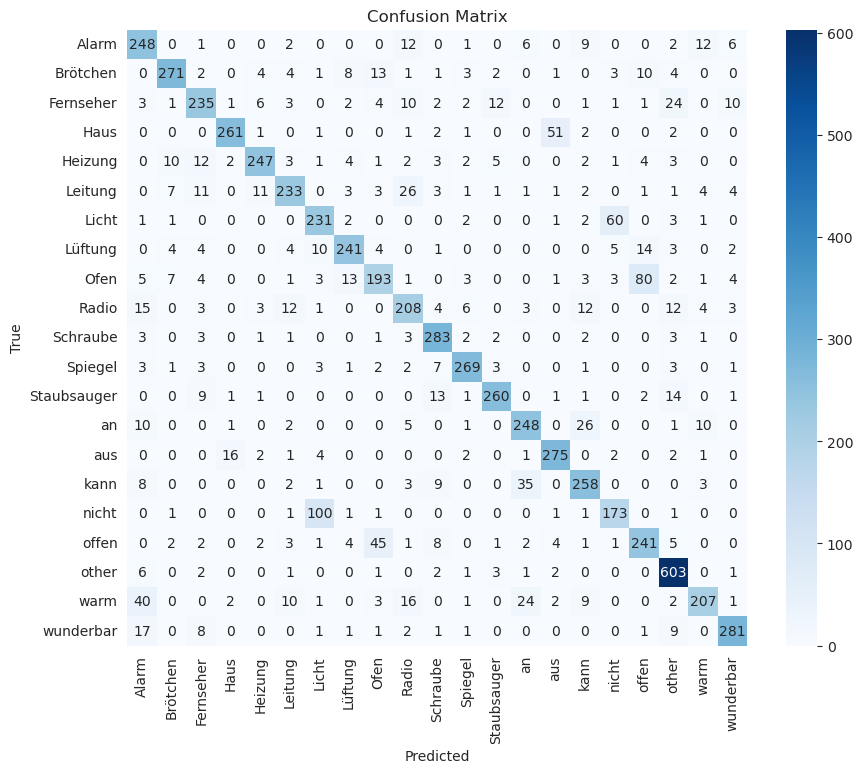

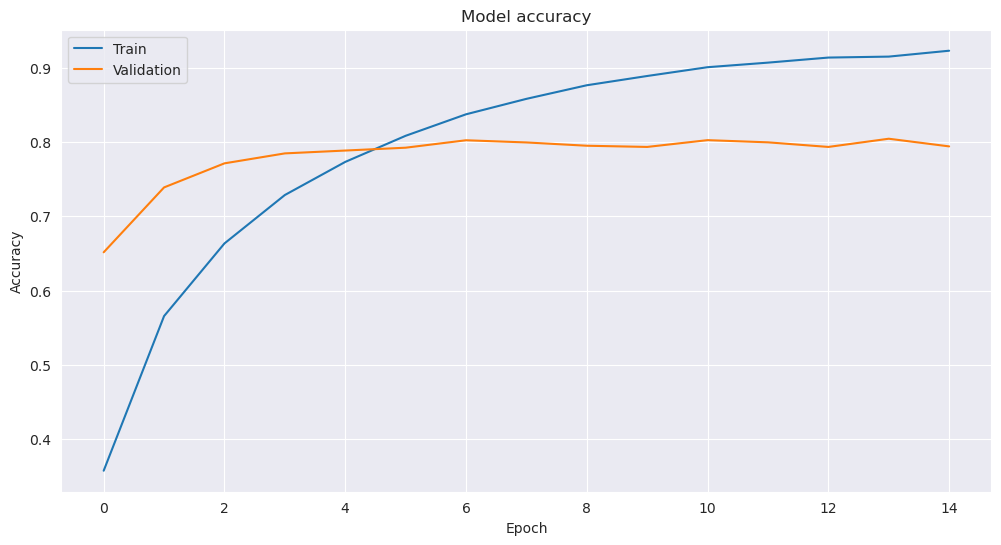

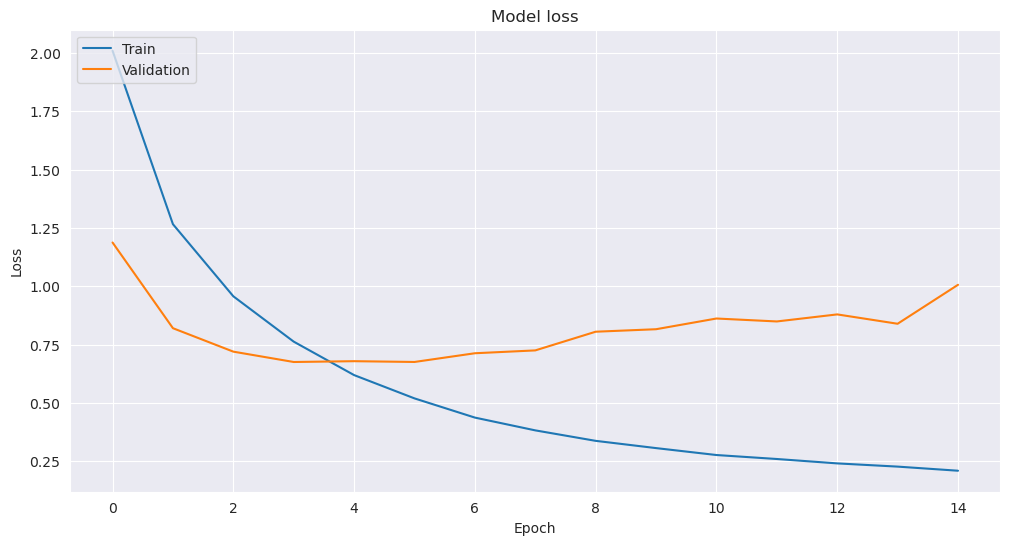

In [12]:
import os

# Ensure the 'fig' directory exists
os.makedirs('fig', exist_ok=True)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred_test = model.predict(X_test_cnn).argmax(axis=1)
y_true_test = y_test_cnn.argmax(axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('fig/confusion_matrix.png')
plt.show()

# Learning Curves
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('fig/learning_curves_accuracy.png')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('fig/learning_curves_loss.png')
plt.show()
